### Try to load the pre-trained model

In [11]:
import os
import re
import pickle
import wget
import shutil
import tarfile
import numpy as np
SETS = ['training', 'validation', 'tests']
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [23]:
if 'models' not in os.listdir('.'):
    os.mkdir('models')
if 'features' not in os.listdir('.'):
    os.mkdir('features')
try:
    dtcwt_rf = pickle.load('models/dtcwt_rf.bin','rb')
    loaded_model = True
except:
    loaded_model = False

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: '../features'

### Load the dataset

In [13]:
import librosa
import numpy as np
from collections import Counter
import scipy
import dtcwt

trans = dtcwt.Transform1d(biort='antonini', qshift='qshift_d')

In [15]:
def calculate_entropy(list_values):
	counter_values = Counter(list_values).most_common()
	probabilities = [elem[1]/len(list_values) for elem in counter_values]
	entropy=scipy.stats.entropy(probabilities)
	return entropy

def calculate_statistics(list_values):
	n5 = np.nanpercentile(list_values, 5)
	n25 = np.nanpercentile(list_values, 25)
	n75 = np.nanpercentile(list_values, 75)
	n95 = np.nanpercentile(list_values, 95)
	median = np.nanpercentile(list_values, 50)
	mean = np.nanmean(list_values)
	std = np.nanstd(list_values)
	var = np.nanvar(list_values)
	rms = np.nanmean(np.sqrt(list_values**2))
	return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
	zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
	no_zero_crossings = len(zero_crossing_indices)
	mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
	no_mean_crossings = len(mean_crossing_indices)
	return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
	entropy = calculate_entropy(list_values)
	crossings = calculate_crossings(list_values)
	statistics = calculate_statistics(list_values)
	return [entropy] + crossings + statistics

In [16]:
def extract_dtcwt(file_path:str):    
    d, fs = librosa.load(file_path)
    forw = trans.forward(d, nlevels=17)
    features = []
    for coeff in forw.highpasses:
        temp = (np.abs(coeff.squeeze()))
        features += get_features(temp)
        
    features += get_features(forw.lowpass.squeeze())    
    return features


In [24]:
def load_from_splits():
    x_features = []
    y  = [] 
    for genre in GENRES:    
        for set in SETS:
            for wav in os.listdir(f'dataset/split/{set}/data/{genre}'):
                if wav == 'jazz.00054.wav': continue
                file_path = f'dataset/split/{set}/data/{genre}/{wav}'
                features = extract_dtcwt(file_path)

                y.append(genre)
                x_features.append(features)
                
    x_features = np.array(x_features)
    y = np.array(y)
    np.save('features/dtcwt_15_lvl17', x_features)
    np.save('features/dtcwt_y', y)
    return x_features,y

try:
    X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
    y = np.load('features/dtcwt_y.npy')
except:
    X_dtcwt, y = load_from_splits()
    X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
    y = np.load('features/dtcwt_y.npy')
X_dtcwt.shape

(999, 216)

In [19]:
def load_from_tar():
    if 'genres.tar.gz' not in os.listdir('dataset'):    
        if os.getenv('COLAB_RELEASE_TAG'):
            # download the GTZAN dataset
            wget.download("https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz")
            shutil.copy2(src='genres.tar.gz', dst='dataset/')
        else:
            raise Exception("Download the GTZAN dataset.")
        
    if 'genres' not in os.listdir('dataset'):
        tar = tarfile.open('dataset/genres.tar.gz', 'r:gz')
        tar.extractall('dataset')
        tar.close()

    x_features = []
    y  = []      
    for genre in GENRES:
        for wav in os.listdir(f'dataset/genres/{genre}'):
            matched = re.match(r"(\w+).(\d+).wav", wav)
            if matched:
                features = extract_dtcwt(f'dataset/genres/{genre}/{wav}')

                y.append(genre)
                x_features.append(features)

    x_features = np.array(x_features)
    y = np.array(y)
    np.save('features/dtcwt_15_lvl17', x_features)
    np.save('features/dtcwt_y', y)
    return x_features,y

try:
    X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
    y = np.load('features/dtcwt_y.npy')
except:
    X_dtcwt, y = load_from_tar()
    X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
    y = np.load('features/dtcwt_y.npy')
X_dtcwt.shape

(999, 216)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
def encoder_scaler(X_dtcwt, y):
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    scaler = StandardScaler()
    X_dtcwt_scaled = scaler.fit_transform(X_dtcwt)
    X_dtcwt_train_f, X_dtcwt_test_f, y_dtcwt_train_f, y_dtcwt_test_f = train_test_split(X_dtcwt_scaled, y, test_size = 0.2,random_state=42)
    return X_dtcwt_train_f, X_dtcwt_test_f, y_dtcwt_train_f, y_dtcwt_test_f

In [25]:
if loaded_model:
    X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
    y = np.load('features/dtcwt_y.npy')
    X_dtcwt_train_f, X_dtcwt_test_f, y_dtcwt_train_f, y_dtcwt_test_f = encoder_scaler(X_dtcwt, y)
    print(dtcwt_rf.score(X_dtcwt_test_f, y_dtcwt_test_f))
    ypred_dtcwt_rf = dtcwt_rf.predict(X_dtcwt_test_f)
else:
    # retrain model
    try:
        X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
        y = np.load('features/dtcwt_y.npy')
    except:
        try:
            X_dtcwt, y = load_from_splits()
            X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
            y = np.load('features/dtcwt_y.npy')
        except:
            try:
                X_dtcwt, y = load_from_tar()
                X_dtcwt = np.load('features/dtcwt_15_lvl17.npy')
                y = np.load('features/dtcwt_y.npy')
            except:
                raise Exception("Can't find GTZAN dataset.")
    X_dtcwt_train_f, X_dtcwt_test_f, y_dtcwt_train_f, y_dtcwt_test_f = encoder_scaler(X_dtcwt, y)
    
    dtcwt_rf = RandomForestClassifier(n_estimators=100,max_depth=13,bootstrap=False,random_state=42)
    dtcwt_rf.fit(X_dtcwt_train_f,y_dtcwt_train_f)
    with open('models/dtcwt_rf.bin','wb') as mod:
        pickle.dump(dtcwt_rf,mod)
    
    print(dtcwt_rf.score(X_dtcwt_test_f, y_dtcwt_test_f))
    ypred_dtcwt_rf = dtcwt_rf.predict(X_dtcwt_test_f)
    

0.795


Plot a confusion matrix to corroborate the behavior of the model for each genre

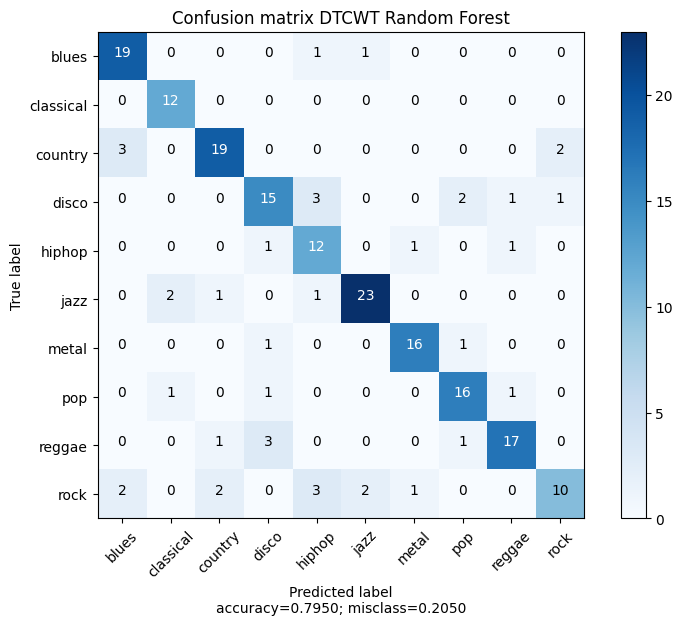

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_dtcwt_test_f, ypred_dtcwt_rf)

accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix DTCWT Random Forest')
plt.colorbar()

tick_marks = np.arange(len(GENRES))
plt.xticks(tick_marks, GENRES, rotation=45)
plt.yticks(tick_marks, GENRES)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > (cm.max() / 2) else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('ConfM_DTCWT_rf.png')

A Cross-Validation using K-Fold to validate the accuracy in the previous fit

scores:  [0.735      0.705      0.8        0.81       0.79396985]
mean:  0.7687939698492463


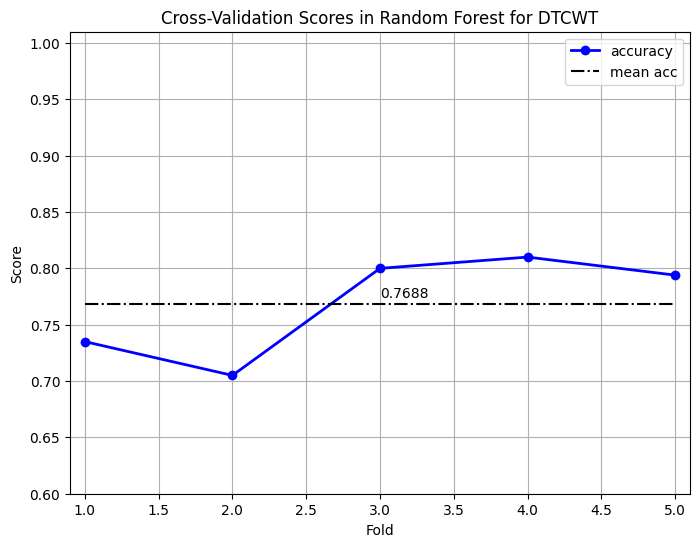

In [28]:
from sklearn.model_selection import KFold, cross_val_score
kfold=KFold(n_splits=5 , shuffle=True,random_state=0) 
rf_scores = cross_val_score(dtcwt_rf, X_dtcwt, y, cv=kfold)

print('scores: ',rf_scores) # [0.735      0.705      0.8        0.81       0.79396985]
print('mean: ',rf_scores.mean()) # 0.7687939698492463

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Cross-Validation Scores in Random Forest for DTCWT')
plt.xlabel('Fold')
plt.ylabel('Score')
ax = plt.gca()
ax.set_xlim(0.9, 5.1)
ax.set_ylim(0.6, 1.01)
plt.grid()
plt.plot(range(1,6),rf_scores,'o-',color='blue',lw=2)
plt.plot(range(1,6),[rf_scores.mean()]*5, linestyle="-.",color='k')
plt.annotate("%0.4f" % rf_scores.mean(), (3,rf_scores.mean() + 0.005))
plt.legend(['accuracy','mean acc'],loc="best")
plt.savefig('CV_DTCWT_rf.png')